# Performance Analysis of 3-target Data with Label Propagation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
import numpy as np
import os
import sys
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Config

In [18]:
window_size = 3000
resolution = 25
step_freq = 3
genome_size = 12000000
num_reads = 1000000
targets = 3
target_binding_size = 50
states = {
    "Background": 0,
    "BindingA": 1,
    "BindingB": 2,
    "BindingC": 3,
    "BindingAB": 4,
    "BindingAC": 5,
    "BindingBC": 6,
    "BindingABC": 7,
}
target_state = 'BindingAB'
training_size = 20
training_peax_initial_sample_size = 60
runs = 5

suffix = f'{genome_size}-{num_reads}'
step_size = window_size // step_freq

bed = f'data/simulated-features-3-targets-{suffix}.bed'
bedBed = f'data/simulated-features-3-targets-{suffix}.bigBed'
bigwigs = [f'data/signal-target-{t}-distorted-peaks-{suffix}.bigWig' for t in np.arange(3) + 1]

import os
cwd = os.chdir('experiments')
# cwd = os.chdir('simulation')
cwd = os.getcwd()
print(cwd)


/Users/anuragmitra/peax/experiments


## Load Datasets

In [19]:
from utils import bed_to_array, chunk_state_array

state_array = bed_to_array(bed, genome_size, states)

for state in states:
    size = 1000 if state == 'Background' else 50
    print(f'Number of {state} windows: {(state_array == states[state]).sum()//size}')

Number of Background windows: 11976
Number of BindingA windows: 69
Number of BindingB windows: 73
Number of BindingC windows: 54
Number of BindingAB windows: 70
Number of BindingAC windows: 63
Number of BindingBC windows: 78
Number of BindingABC windows: 65


In [20]:
positive_windows = chunk_state_array(
    (state_array == states[target_state]).astype(np.uint8),
    window_size,
    resolution,
    step_size,
    (target_binding_size // resolution)
)
print(f'There are {positive_windows.sum()} windows with the target')

There are 199 windows with the target


In [21]:
from server.bigwig import chunk

windows_signals = []
for target in range(targets):
    windows_signals.append(chunk(
        bigwigs[target],
        window_size,
        resolution,
        step_size,
        ['chr1'],
        verbose=True,
    ))
    
concat_windows_signals = np.concatenate(windows_signals, axis=1)

num_windows = windows_signals[0].shape[0]

Extracted 11998 windows from chr1 with a max value of 1.0.
Extracted 11998 windows from chr1 with a max value of 1.0.
Extracted 11998 windows from chr1 with a max value of 1.0.


**Double check that the labels are correct**

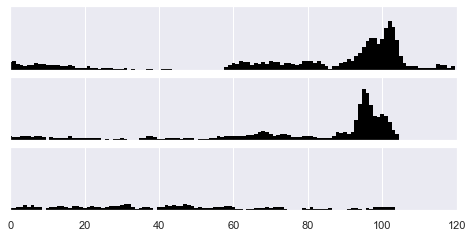

In [22]:
from utils import plot_windows

plot_windows(windows_signals, [np.where(positive_windows == 1)[0][0]])

# Classifier Training

In [23]:
from sklearn.metrics import f1_score, matthews_corrcoef, precision_score, recall_score, roc_auc_score, average_precision_score
from multiprocessing import Pool

In [24]:
def predict_proba_ordered(probs, classes_, all_classes=np.array([0,1])):
    """
    probs: list of probabilities, output of predict_proba 
    classes_: clf.classes_
    all_classes: all possible classes (superset of classes_)
    """
    proba_ordered = np.zeros((probs.shape[0], all_classes.size),  dtype=np.float)
    sorter = np.argsort(all_classes) # http://stackoverflow.com/a/32191125/395857
    idx = sorter[np.searchsorted(all_classes, classes_, sorter=sorter)]
    proba_ordered[:, idx] = probs
    return proba_ordered

In [30]:
import os
cwd = os.chdir('simulation')
cwd = os.getcwd()
print(cwd)

/Users/anuragmitra/peax/experiments/simulation


## Encode and concat data

In [32]:
from server.encoder import Autoencoder

with open('../../examples/autoencoders.json', 'r') as f:
    autoencoders = json.load(f)

ae_config = autoencoders['histone-mark-chip-seq-3kb'].copy()
ae_config['autoencoder_filepath'] = os.path.join('../../', ae_config['autoencoder'])
del ae_config['autoencoder']

encoder = Autoencoder(**ae_config)

# Encode windows
encoded_windows_signals = [encoder.encode(x.reshape(*x.shape, 1)) for x in windows_signals]

# Concat encoded windows
concat_encoded_windows_signals = np.concatenate(encoded_windows_signals, axis=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Pick a representative target and encode it

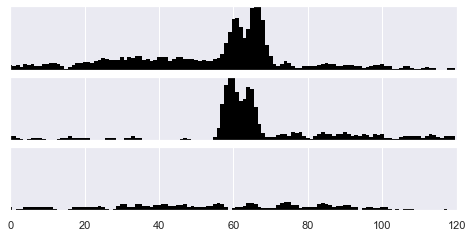

In [33]:
import bbi

positive_windows_idx = np.where(positive_windows == 1)[0]

search_target_idx = positive_windows_idx[15]

search_target_raw = []
for windows_signal in windows_signals:
    search_target_raw.append(np.concatenate((
        windows_signal[search_target_idx][0:120],
        windows_signal[search_target_idx + 1][:0],
    )).reshape(1, 120))

concat_search_target_raw = np.concatenate(search_target_raw, axis=1)
concat_search_target_encoded = np.concatenate([encoder.encode(x.reshape(*x.shape, 1)) for x in search_target_raw], axis=1)

plot_windows(search_target_raw, [0])

### Calculate the distance to the target and knn-neighborhood distance

### Label propagation

In [34]:
from sklearn.neighbors import NearestNeighbors

def propagate_labels(
    data,
    directly_labeled_windows,
    window_labels,
    window_label_weights,
    weight_decay_step: float = 0.95,
    weight_decay_pos: float = 0.66,
    weight_decay_neg: float = 0.66
):
    # Temporarily switch negative labels from 0 to -1 for convenience
    labeled_window_mask = np.zeros(window_labels.size).astype(bool)
    labeled_window_mask[directly_labeled_windows] = True
    
    # We need to find the 2 nearest neighbors since the node itself is included as the nearest neighbor...
    nbrs = NearestNeighbors(n_neighbors=2, n_jobs=-1)
    nbrs.fit(data)
    
    # The first column of `distances` and `indices` is useless as it's always the node itself...
    distances, indices = nbrs.kneighbors(data)
    
    def give_labels(source_windows):
        """The source windows 'give' their label to their nearest neighbor"""
        nn_of_source_windows = indices[source_windows, 1]
        
        # ~window_labels[nn_of_source_windows].astype(bool) will be `True` for all windows that do not have a label yet
        unlabeled_nn_mask = ~labeled_window_mask[nn_of_source_windows].astype(bool)
        num_unlabeled_nn = unlabeled_nn_mask.sum()
        
        # Unlabeled windows that are the nearest neighbor of the sources
        targets = nn_of_source_windows[unlabeled_nn_mask]
        # Source windows with an unlabeled nearest neighbors are the sources
        sources = source_windows[unlabeled_nn_mask]

        # Assign source labels to their nearest neighbor
        window_labels[targets] = window_labels[sources]

        # Assign weights
        window_label_weights[targets] = window_label_weights[sources] * weight_decay_step
        
        # Determine decay for positively labeled windows
        # When nn window is farther away from the target then the source we decay the weight as the chances are higher that it's not a true positive
        decay_weight_of_pos_nn = np.logical_and(
            window_labels[sources] == 1,
            dist_to_target[sources] < dist_to_target[targets]
        )
        
        window_label_weights[targets[decay_weight_of_pos_nn]] *= weight_decay_pos
        
        # Determine decay for negatively labeled windows
        # When nn window is closer to the target then the source we decay the weight as the chances are higher that it's not a true negative
        decay_weight_of_neg_nn = np.logical_and(
            window_labels[sources] == 0,
            dist_to_target[sources] > dist_to_target[targets]
        )
        
        window_label_weights[targets[decay_weight_of_neg_nn]] *= weight_decay_neg
        
        # Update label mask
        labeled_window_mask[targets] = True
    
        return targets, num_unlabeled_nn
    
    def take_labels():
        """The source windows take the label from their nearest neighbors"""        
        unlabeled_windows = np.where(labeled_window_mask == False)[0]
        nn_of_unlabeled_windows = indices[unlabeled_windows, 1]
        
        labeled_nn_mask = labeled_window_mask[nn_of_unlabeled_windows]
        num_labeled_nn = labeled_nn_mask.sum()
        
        # Unlabeled window with a labeled nearest neighbor are the target
        targets = unlabeled_windows[labeled_nn_mask]
        # Labeled nearest neighbors are the source
        sources = nn_of_unlabeled_windows[labeled_nn_mask]

        # Assign the label of the nns to the unlabeled source
        window_labels[targets] = window_labels[sources]

        # Assign weights
        window_label_weights[targets] = window_label_weights[sources] * weight_decay_step
        
        # Determine decay for positively labeled windows
        # When nn window is farther away from the target then the source we decay the weight as the chances are higher that it's not a true positive
        decay_weight_of_pos_nn = np.logical_and(
            window_labels[sources] == 1,
            dist_to_target[sources] < dist_to_target[targets]
        )
        
        window_label_weights[targets[decay_weight_of_pos_nn]] *= weight_decay_pos
        
        # Determine decay for negatively labeled windows
        # When nn window is closer to the target then the source we decay the weight as the chances are higher that it's not a true negative
        decay_weight_of_neg_nn = np.logical_and(
            window_labels[sources] == 0,
            dist_to_target[sources] > dist_to_target[targets]
        )
        
        window_label_weights[targets[decay_weight_of_neg_nn]] *= weight_decay_neg
        
        # Update label mask
        labeled_window_mask[targets] = True
    
        return num_labeled_nn
    
    windows_with_newly_given_label, num_newly_given_window_labels = give_labels(
        np.where(directly_labeled_windows == True)[0]
    )
    
    num_newly_taken_window_labels = take_labels()
    
    while num_newly_given_window_labels + num_newly_taken_window_labels > 0:
        windows_with_newly_given_label, num_newly_given_window_labels = give_labels(windows_with_newly_given_label)
    
        num_newly_taken_window_labels = take_labels()

In [38]:
from metric_learn import NCA, LMNN
from scipy.spatial.distance import cdist

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from server.sampling import sample_by_dist_density, sample_by_uncertainty_dist_density
from server import utils

def analyze_al_encoded(
    Classifier=lambda: RandomForestClassifier(n_estimators=1000, n_jobs=-1),
    classifier_fit=lambda classifier, X, y, weights: classifier.fit(X, y, weights),
    max_direct_train_labels=num_windows,
    label_prop=False,
    label_prop_with_metric_learning=False,
    al_with_metric_learning=False,
    verbose=False
):
    if verbose:
        print("Run started...")

    dist_metric = 'euclidean'

    dist_to_target = cdist(concat_encoded_windows_signals, concat_search_target_encoded, dist_metric).flatten()

    knn_density = utils.knn_density(concat_encoded_windows_signals)

    metrics = {
        "f1": [],
        "mcc": [],
        "precision": [],
        "recall": [],
        "roc_auc": [],
        "avg_precision": [],
    }

    ml_model = NCA()
    
    directly_labeled_windows = np.zeros(num_windows).astype(bool)
    indirectly_labeled_windows = np.zeros(num_windows).astype(bool)
    window_label_weights = np.zeros(num_windows)
    window_labels = np.zeros(num_windows).astype(np.uint8)

    classifier = Classifier()

    start = time.time()

    f1_al_encoded = []
    mcc_al_encoded = []
    precision_al_encoded = []
    recall_al_encoded = []
    log_loss_al_encoded = []

    # First round with our initial sampling strategy
    data_selection = ~directly_labeled_windows
    data_selection[np.where(concat_windows_signals.max(axis=1) < 0.1)] = False # Filter out almost empty regions

    direct_samples = sample_by_dist_density(
        concat_encoded_windows_signals,
        data_selection,
        dist_to_target,
        knn_density,
        levels=6,
        level_sample_size=10,
        initial_level_size=20,
    )

    directly_labeled_windows[direct_samples] = True
    window_labels[direct_samples] = positive_windows[direct_samples]
    window_label_weights[direct_samples] = 1
    
    if label_prop_with_metric_learning or al_with_metric_learning:
        # Learn Metric
        ml_model.fit(
            concat_encoded_windows_signals[directly_labeled_windows],
            window_labels[directly_labeled_windows]
        )

    if label_prop:
        data_for_label_propagation = concat_encoded_windows_signals
        
        if label_prop_with_metric_learning:
            data_for_label_propagation = ml_model.transform(concat_encoded_windows_signals)
            
        propagate_labels(
            data_for_label_propagation,
            directly_labeled_windows,
            window_labels,
            window_label_weights
        )

    currently_labeled_windows = np.where(window_label_weights > 0)[0]

    classifier_fit(
        classifier,
        concat_encoded_windows_signals[currently_labeled_windows],
        window_labels[currently_labeled_windows],
        window_label_weights[currently_labeled_windows]
    )

    y_pred = classifier.predict(concat_encoded_windows_signals)
    prob_pred = predict_proba_ordered(
        classifier.predict_proba(concat_encoded_windows_signals),
        classifier.classes_
    )[:,1]

    f1 = f1_score(positive_windows, y_pred)
    metrics['f1'].append(f1)

    mcc = matthews_corrcoef(positive_windows, y_pred)
    metrics['mcc'].append(mcc)

    precision = precision_score(positive_windows, y_pred)
    metrics['precision'].append(precision)

    recall = recall_score(positive_windows, y_pred)
    metrics['recall'].append(recall)

    avg_precision = average_precision_score(positive_windows, prob_pred)
    metrics['avg_precision'].append(avg_precision)

    roc_auc = roc_auc_score(positive_windows, prob_pred)
    metrics['roc_auc'].append(roc_auc)

    dt = (time.time() - start) / 60

    if verbose:
        print(f'The first round of training with {currently_labeled_windows.size} labels ({directly_labeled_windows.sum()} direct labels) took {dt:.1f} mins.')
        print(f'↳ Precision: {precision:.3f} Recall: {recall:.3f} F1: {f1:.3f} MCC: {mcc:.3f} Avg. Precision: {avg_precision:.3f} ROC AUC: {roc_auc:.3f}')
        print(f'  ↳ {positive_windows[currently_labeled_windows].sum()} positive labels used')
    

    # Subsequent round with out active learning sampling strategy
    for i in range(directly_labeled_windows.sum(), max_direct_train_labels, training_size):
        sample_size = min((~directly_labeled_windows).sum(), training_size)

        if al_with_metric_learning:
            concat_encoded_windows_signals_transformed = ml_model.transform(concat_encoded_windows_signals)
            
            direct_samples = sample_by_uncertainty_dist_density(
                concat_encoded_windows_signals_transformed,
                ~directly_labeled_windows,
                cdist(
                    concat_encoded_windows_signals_transformed,
                    ml_model.transform(concat_search_target_encoded),
                    dist_metric
                ).flatten(),
                utils.knn_density(concat_encoded_windows_signals_transformed),
                y_pred,
                n=sample_size,
            )
        else:
            direct_samples = sample_by_uncertainty_dist_density(
                concat_encoded_windows_signals,
                ~directly_labeled_windows,
                dist_to_target,
                knn_density,
                y_pred,
                n=sample_size,
            )

        directly_labeled_windows[direct_samples] = True
        window_labels[direct_samples] = positive_windows[direct_samples]
        window_label_weights[direct_samples] = 1
        
        if label_prop_with_metric_learning or al_with_metric_learning:
            # Learn Metric
            ml_model.fit(
                concat_encoded_windows_signals[directly_labeled_windows],
                window_labels[directly_labeled_windows]
            )

        if label_prop:
            data_for_label_propagation = concat_encoded_windows_signals
            
            if label_prop_with_metric_learning:
                ml_model.transform(concat_encoded_windows_signals)
                
            propagate_labels(
                data_for_label_propagation,
                directly_labeled_windows,
                window_labels,
                window_label_weights
            )

        currently_labeled_windows = np.where(window_label_weights > 0)[0]

        classifier_fit(
            classifier,
            concat_encoded_windows_signals[currently_labeled_windows],
            window_labels[currently_labeled_windows],
            window_label_weights[currently_labeled_windows]
        )

        y_pred = classifier.predict(concat_encoded_windows_signals)
        prob_pred = predict_proba_ordered(
            classifier.predict_proba(concat_encoded_windows_signals),
            classifier.classes_
        )[:,1]

        f1 = f1_score(positive_windows, y_pred)
        metrics['f1'].append(f1)

        mcc = matthews_corrcoef(positive_windows, y_pred)
        metrics['mcc'].append(mcc)

        precision = precision_score(positive_windows, y_pred)
        metrics['precision'].append(precision)

        recall = recall_score(positive_windows, y_pred)
        metrics['recall'].append(recall)

        avg_precision = average_precision_score(positive_windows, prob_pred)
        metrics['avg_precision'].append(avg_precision)

        roc_auc = roc_auc_score(positive_windows, prob_pred)
        metrics['roc_auc'].append(roc_auc)

        dt = (time.time() - start) / 60
        num_rounds = len(metrics['f1'])

        if verbose and directly_labeled_windows.sum() % 100 == 0:
            print(f'{num_rounds} rounds of training with {currently_labeled_windows.size} labels ({directly_labeled_windows.sum()} direct labels) took {dt:.1f} mins.')
            print(f'↳ Precision: {precision:.3f} Recall: {recall:.3f} F1: {f1:.3f} MCC: {mcc:.3f} Avg. Precision: {avg_precision:.3f} ROC AUC: {roc_auc:.3f}')
            print(f'  ↳ {positive_windows[currently_labeled_windows].sum()} positive labels used')
    
    dt = (time.time() - start) / 60
    if verbose:
        print(f"Run ended after {dt:.1f} mins.")
        print("")
    
    return metrics

In [39]:
test = analyze_al_encoded(
    lambda: KNeighborsClassifier(n_jobs=-1),
    lambda classifier, X, y, weights: classifier.fit(X, y),
    max_direct_train_labels=200,
    label_prop=False,
    label_prop_with_metric_learning=False,
    al_with_metric_learning=False,
    verbose=True
)

Run started...
The first round of training with 60 labels (60 direct labels) took 0.0 mins.
↳ Precision: 0.383 Recall: 0.387 F1: 0.385 MCC: 0.375 Avg. Precision: 0.314 ROC AUC: 0.864
  ↳ 19 positive labels used
3 rounds of training with 100 labels (100 direct labels) took 0.0 mins.
↳ Precision: 0.461 Recall: 0.327 F1: 0.382 MCC: 0.379 Avg. Precision: 0.320 ROC AUC: 0.828
  ↳ 21 positive labels used
8 rounds of training with 200 labels (200 direct labels) took 0.1 mins.
↳ Precision: 0.557 Recall: 0.342 F1: 0.424 MCC: 0.429 Avg. Precision: 0.368 ROC AUC: 0.814
  ↳ 28 positive labels used
Run ended after 0.1 mins.



### Run cross validation

In [40]:
repeats = 10
max_direct_train_labels = 200

classifiers = {
    'RF': lambda: RandomForestClassifier(n_estimators=500, n_jobs=-1),
    'Ada': lambda: AdaBoostClassifier(n_estimators=250),
    'Naive Bayes': lambda: GaussianNB(),
    'KNN': lambda: KNeighborsClassifier(n_jobs=-1),
}

classifiers_fit = {
    'RF': lambda classifier, X, y, weights: classifier.fit(X, y, weights),
    'Ada': lambda classifier, X, y, weights: classifier.fit(X, y, weights),
    'Naive Bayes': lambda classifier, X, y, weights: classifier.fit(X, y, weights),
    'KNN': lambda classifier, X, y, weights: classifier.fit(X, y),
}

conditions = ['Default', 'Label Prop.', 'Label Prop. with Metric Learning', 'Label Prop. and AL with Metric Learning', 'AL with Metric Learning']
conditional_params = [
    {},
    {
        "label_prop": True,
    },
    {
        "label_prop": True,
        "label_prop_with_metric_learning": True,
    },
    {
        "label_prop": False,
        "label_prop_with_metric_learning": True,
        "al_with_metric_learning": True,
    },
    {
        "al_with_metric_learning": True,
    }
]

all_results = {}
for classifier in classifiers:
    all_results[classifier] = {
        "f1": [],
        "mcc": [],
        "precision": [],
        "recall": [],
        "roc_auc": [],
        "avg_precision": [],
    }

start = time.time()

for i, params in enumerate(conditional_params):
    print(f'Run {conditions[i]}')
    for classifier_name, Classifier in classifiers.items():
        print(f'↳ {classifier_name}', end='')
        
        for metric in all_results[classifier_name]:
            all_results[classifier_name][metric].append([])
        
        for r in range(repeats):
            print(f'.', end='')
            results = analyze_al_encoded(
                Classifier,
                classifiers_fit[classifier_name],
                max_direct_train_labels,
                **params
            )
            for metric, value in results.items():
                all_results[classifier_name][metric][i].append(value)
        print(' ', end='')
    print('done!')
print(f'Total cross validation took {((time.time()-start)/60):.2f} mins')

Run Default
↳ RF.......... ↳ Ada.......... ↳ Naive Bayes.......... ↳ KNN.......... done!
Run Label Prop.
↳ RF.

NameError: name 'dist_to_target' is not defined

In [ ]:
import pandas as pd

def get_data(values, training_labels=20, intial_training_labels=60, y_label='y'):
    data = []

    num_runs = len(values)
    num_trainings = len(values[0])
    
    for run in range(num_runs):
        tmp = np.zeros((num_trainings, 2))
        
        tmp[0,0] = intial_training_labels
        tmp[0,1] = values[run][0]
        
        tmp[1:,0] = np.arange(1, num_trainings) * training_labels + intial_training_labels
        tmp[1:,1] = np.array(values[run])[1:]
        
        data.append(pd.DataFrame(tmp, columns=['# Labels', y_label]))

    return pd.concat(data)

In [ ]:
fig, axes = plt.subplots(
    len(all_results['RF']), len(all_results), figsize=(20, 24), gridspec_kw=dict(wspace=0.2, hspace=0.2)
)

sns.set(style="whitegrid")

conditions_short = ['None', 'Label Prop.', 'Label Prop. w/ ML', 'Label Prop. & AL w/ ML', 'AL w/ ML']

for col, classifier in enumerate(classifiers):
    for row, metric in enumerate(all_results[classifier]):
        y_max = np.array(all_results[classifier][metric]).max()
        y_lim = (0, min(1, y_max + 0.025))
        ax = axes[row, col]
                  
        for condition in range(len(conditions)):
            data = get_data(
                all_results[classifier][metric][condition],
                training_size,
                training_peax_initial_sample_size,
                y_label=metric
            )
        
            sns.lineplot(
                x='# Labels',
                y=metric,
                data=data,
                ax=ax,
                label=conditions_short[condition]
            )
            
            ax.set_ylim(y_lim)
            
        if col > 0:
            ax.set_ylabel(None)
        if row < 5:
            ax.set_xlabel(None)
        if row == 0:
            ax.set_title(classifier)

In [ ]:
with Pool(processes=4) as pool:
    results_new = [pool.apply(analyze_al_encoded) for n in range(runs)]

metrics_al_encoded_new = {
    "f1": [x['f1'] for x in results_new],
    "mcc": [x['mcc'] for x in results_new],
    "precision": [x['precision'] for x in results_new],
    "recall": [x['recall'] for x in results_new],
    "log_loss": [x['log_loss'] for x in results_new],
}

In [ ]:
if not os.path.exists('data/metrics-al-encoded-new.json'):
    with open('data/metrics-al-encoded-new.json', 'w') as f:
        json.dump(metrics_al_encoded_new, f)

## Plot Results

In [ ]:
methods = []
method_names = []
metrics = ['f1', 'mcc', 'precision', 'recall', 'log_loss']
metric_names = ['F1', 'MCC', 'Precision', 'Recall', 'Log Loss']

with open('data/metrics-random-raw.json', 'r') as f:
    methods.append(json.load(f))
    method_names.append('Random Raw')

with open('data/metrics-random-encoded.json', 'r') as f:
    methods.append(json.load(f))
    method_names.append('Random Encoded')

with open('data/metrics-al-encoded-new.json', 'r') as f:
    methods.append(json.load(f))
    method_names.append('Active Learning Encoded')
    
fig, axes = plt.subplots(
    2,
    3,
    figsize=(5 * 3, 5 * 2),
)

plt.style.use('seaborn-whitegrid')

for metric_idx, metric in enumerate(metrics):
    col = metric_idx // 2
    row = metric_idx % 2
    
    axis = axes[row, col]
    axis.set_title(metric_names[metric_idx])
    
    for method_idx, method in enumerate(methods):
        sns.lineplot(
            x='x',
            y='y',
            data=get_data(method[metric], n_first_steps),
            ax=axis,
            label=None if metric_idx > 0 else method_names[method_idx]
        )